<a href="https://colab.research.google.com/github/NicKylis/letter_recognition/blob/layman/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Lightweight class classification model</center></h1>

In this project we will attempt to build a model that is as accurate as possible with a parameter amount at around 100 thousand parameters. As the amount is very low, we will refrain from most usual architecture methods. First of all lets import the required libraries.

In [42]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Dense, Conv2DTranspose, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.regularizers import l2
from cv2 import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import seaborn as sns

We will now create our datasets. We will utilize light data augmentation. The datasets we will test our algorithm are the following:
- The MNIST dataset
- The fashion MNIST dataset
- The cifar10 dataset
We create a function to load them according to the option we choose for our ease.

In [2]:
def get_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42, option='MNIST'):
    data = ''
    if(option == 'MNIST'):
        data = tf.keras.datasets.mnist
    elif(option == 'fashionMNIST'):
        data = tf.keras.datasets.fashion_mnist
    elif(option == 'cifar10'):
        data = tf.keras.datasets.cifar10
        
    (x_train, y_train), (x_test, y_test) = data.load_data()

    if option != 'cifar10':
        x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
        x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
    else:
        x_train = x_train.astype("float32") / 255.0
        x_test = x_test.astype("float32") / 255.0
    #Split data to train and valitation
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_split, random_state=random_state)

    num_classes = 10  # MNIST has 10 classes (digits 0-9)
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    #Use default ImageDataGenerator for inmutable images
    val_test_generator = ImageDataGenerator()
    train_gen = train_generator.flow(x_train, y_train, batch_size=batch_size)
    val_gen = val_test_generator.flow(x_val, y_val, batch_size=batch_size)
    test_gen = val_test_generator.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

    return train_gen, val_gen, test_gen, y_test

We then create the image generators. We will use a 20% train/validation data split and 5 types of transformation for data augmenting.

In [3]:
train_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2)

train_data_mnist, val_data_mnist, test_data_mnist, y_true_mnist = get_dataset(train_generator, batch_size=64, val_split=0.2, random_state=42, option='MNIST')
train_data_fashion_mnist, val_data_fashion_mnist, test_data_fashion_mnist, y_true_fashion_mnist = get_dataset(train_generator, batch_size=64, val_split=0.2, random_state=42, option='fashionMNIST')
train_data_cifar10, val_data_cifar10, test_data_cifar10, y_true_cifar10 = get_dataset(train_generator, batch_size=64, val_split=0.2, random_state=42, option='cifar10')

We now create the model's architecture and layers. As we are pressed for parameters(and size), we will decide to use 5 layers of 2 DepthWiseConv2D (ADD DATA HERE ITS IMPORTANT)filters followed by a conventional convolutional layer. That way we both have depth and keep the size low. We also set the optimizer to start at a higher amount than the usual (2e-3 instead of 1e-3). This will help mainly for our more complex datasets, namely the cifar dataset and a little bit for our fashion MNIST dataset. Finally,  as a loss function we use categorical crossentropy, which is the most common loss function for these kind of models. We add label smoothing in order to refrain from making our model too certain on its wrong decisions.

In [20]:
def create_model(option='MNIST'):
    model = keras.Sequential()
    if(option=='MNIST' or option=='fashionMNIST'):  
        model.add(Conv2D(16, (5, 5), strides=(1, 1), activation=None, padding='same', input_shape=(28, 28, 1)))
    else:
        model.add(Conv2D(16, (5, 5), strides=(1, 1), activation=None, padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2D(32, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax')) 

    optimizer = Adam(learning_rate=2e-3)
    loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=['accuracy', 'Precision', 'Recall'])
    model.summary()

    return model

model_mnist = create_model(option='MNIST')
model_fashion_mnist = create_model(option='fashionMNIST')
model_cifar10 = create_model(option='cifar10')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 28, 28, 16)        416       
                                                                 
 batch_normalization_138 (Ba  (None, 28, 28, 16)       64        
 tchNormalization)                                               
                                                                 
 re_lu_138 (ReLU)            (None, 28, 28, 16)        0         
                                                                 
 depthwise_conv2d_82 (Depthw  (None, 28, 28, 16)       160       
 iseConv2D)                                                      
                                                                 
 batch_normalization_139 (Ba  (None, 28, 28, 16)       64        
 tchNormalization)                                               
                                                     

We also create custom scheduler and callback functions.

In [21]:
lr_scheduler_mnist = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.5, min_lr=5e-5)
lr_scheduler_fashion_mnist = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.5, min_lr=5e-5)
lr_scheduler_cifar10 = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.5, min_lr=5e-5)
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

We will now train our models. We will use a higher amount of epochs for our cifar10 dataset, as it is trained more slowly. NOTE: If more time is given all models except the standard MNIST model can be further trained for more accuracy.

In [22]:
history_cifar10 = model_cifar10.fit(train_data_cifar10,
         validation_data=val_data_cifar10,
         epochs=80,
         batch_size=64,
         shuffle=True
         ,callbacks=[lr_scheduler_cifar10])

Epoch 1/80
625/625 [==============================] - 20s 28ms/step - loss: 1.9310 - accuracy: 0.3237 - precision: 0.6015 - recall: 0.0530 - val_loss: 1.8786 - val_accuracy: 0.3681 - val_precision: 0.5936 - val_recall: 0.0682 - lr: 0.0020
Epoch 2/80
625/625 [==============================] - 18s 28ms/step - loss: 1.6955 - accuracy: 0.4517 - precision: 0.6948 - recall: 0.1648 - val_loss: 2.3243 - val_accuracy: 0.3224 - val_precision: 0.4077 - val_recall: 0.2376 - lr: 0.0020
Epoch 3/80
625/625 [==============================] - 17s 28ms/step - loss: 1.5835 - accuracy: 0.5105 - precision: 0.7366 - recall: 0.2514 - val_loss: 1.6056 - val_accuracy: 0.4809 - val_precision: 0.6552 - val_recall: 0.3116 - lr: 0.0020
Epoch 4/80
625/625 [==============================] - 18s 28ms/step - loss: 1.4977 - accuracy: 0.5557 - precision: 0.7655 - recall: 0.3149 - val_loss: 1.4554 - val_accuracy: 0.5714 - val_precision: 0.7358 - val_recall: 0.4230 - lr: 0.0020
Epoch 5/80
625/625 [========================

In [23]:
history_fashion_mnist = model_fashion_mnist.fit(train_data_fashion_mnist,
         validation_data=val_data_fashion_mnist,
         epochs=60,
         batch_size=64,
         shuffle=True
         ,callbacks=[lr_scheduler_fashion_mnist])

Epoch 1/60
750/750 [==============================] - 38s 48ms/step - loss: 1.3693 - accuracy: 0.6086 - precision: 0.8411 - recall: 0.3937 - val_loss: 1.0171 - val_accuracy: 0.7601 - val_precision: 0.8831 - val_recall: 0.6398 - lr: 0.0020
Epoch 2/60
750/750 [==============================] - 25s 33ms/step - loss: 1.1111 - accuracy: 0.7313 - precision: 0.8713 - recall: 0.5700 - val_loss: 1.0063 - val_accuracy: 0.7727 - val_precision: 0.8305 - val_recall: 0.7117 - lr: 0.0020
Epoch 3/60
750/750 [==============================] - 14s 19ms/step - loss: 1.0489 - accuracy: 0.7669 - precision: 0.8817 - recall: 0.6284 - val_loss: 0.9222 - val_accuracy: 0.8134 - val_precision: 0.8731 - val_recall: 0.7506 - lr: 0.0020
Epoch 4/60
750/750 [==============================] - 14s 18ms/step - loss: 1.0094 - accuracy: 0.7891 - precision: 0.8898 - recall: 0.6629 - val_loss: 0.9061 - val_accuracy: 0.8132 - val_precision: 0.8768 - val_recall: 0.7490 - lr: 0.0020
Epoch 5/60
750/750 [========================

In [24]:
history_mnist = model_mnist.fit(train_data_mnist,
         validation_data=val_data_mnist,
         epochs=50,
         batch_size=64,
         shuffle=True
         ,callbacks=[lr_scheduler_mnist])

Epoch 1/50
750/750 [==============================] - 15s 19ms/step - loss: 1.1521 - accuracy: 0.7493 - precision: 0.9286 - recall: 0.5977 - val_loss: 0.7950 - val_accuracy: 0.8953 - val_precision: 0.9468 - val_recall: 0.8351 - lr: 0.0020
Epoch 2/50
750/750 [==============================] - 14s 18ms/step - loss: 0.7487 - accuracy: 0.9354 - precision: 0.9667 - recall: 0.8811 - val_loss: 0.6584 - val_accuracy: 0.9465 - val_precision: 0.9650 - val_recall: 0.9247 - lr: 0.0020
Epoch 3/50
750/750 [==============================] - 13s 17ms/step - loss: 0.7037 - accuracy: 0.9515 - precision: 0.9747 - recall: 0.9081 - val_loss: 0.5881 - val_accuracy: 0.9769 - val_precision: 0.9856 - val_recall: 0.9635 - lr: 0.0020
Epoch 4/50
750/750 [==============================] - 12s 17ms/step - loss: 0.6865 - accuracy: 0.9572 - precision: 0.9777 - recall: 0.9190 - val_loss: 0.5783 - val_accuracy: 0.9783 - val_precision: 0.9864 - val_recall: 0.9696 - lr: 0.0020
Epoch 5/50
750/750 [========================

We now save our models in all kinds of ways in order to ensure we do not lose their weights (it has happened before so better safe than sorry).

In [25]:
model_mnist.save('model_mnist.h5')
model_mnist.save('model_mnist.keras')
model_fashion_mnist.save('model_fashion_mnist.h5')
model_fashion_mnist.save('model_fashion_mnist.keras')
model_cifar10.save('model_cifar10.h5')
model_cifar10.save('model_cifar10.keras')

model_mnist.save_weights('mnist_weights.h5')
model_mnist.save_weights('mnist_weights.ckpt')
model_fashion_mnist.save_weights('fashion_mnist_weights.h5')
model_fashion_mnist.save_weights('fashion_mnist_weights.ckpt')
model_cifar10.save_weights('cifar_weights.h5')
model_cifar10.save_weights('cifar_weights.ckpt')

Lets now visualize our accuracy and loss along our epochs.

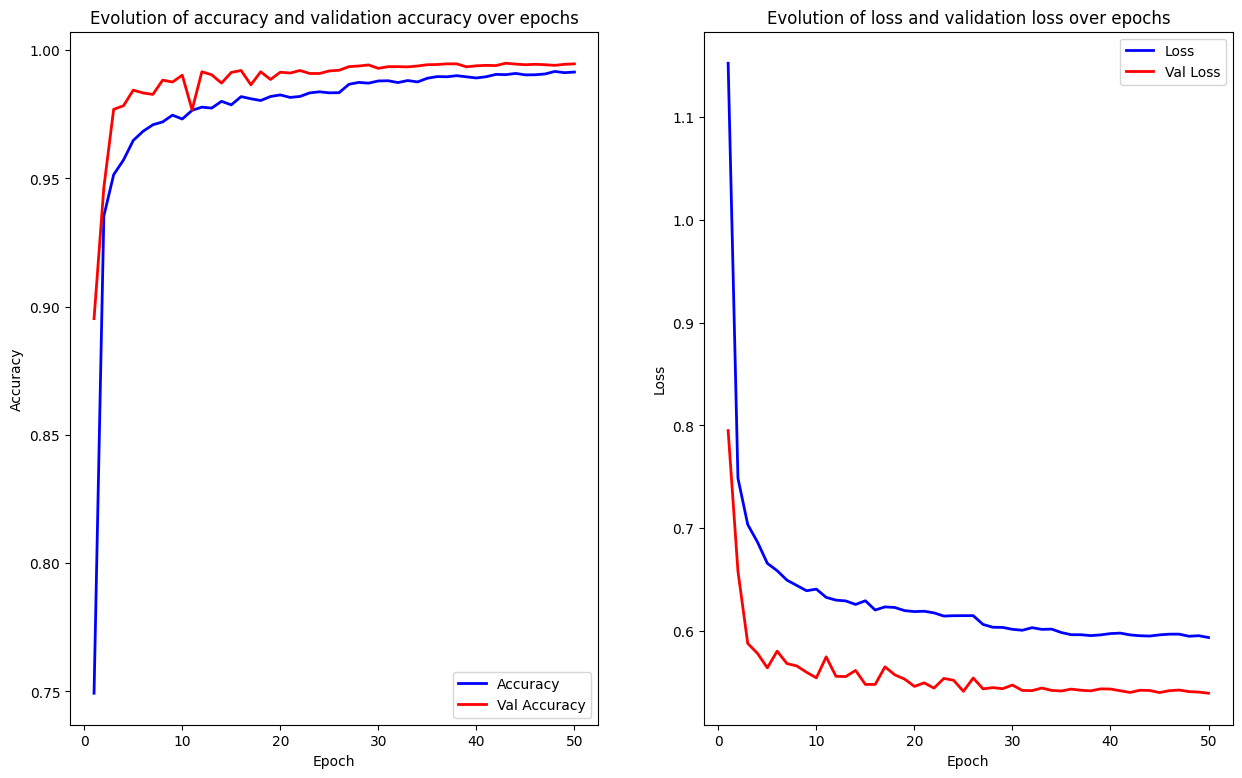

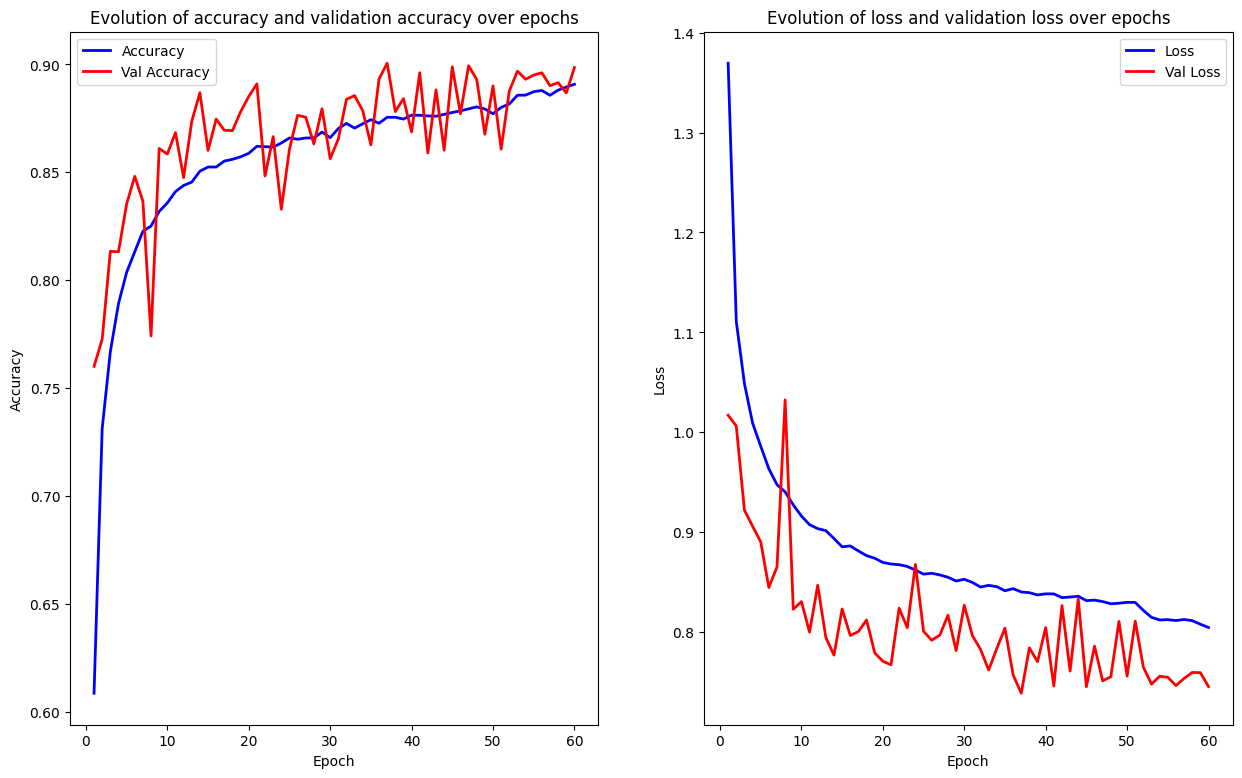

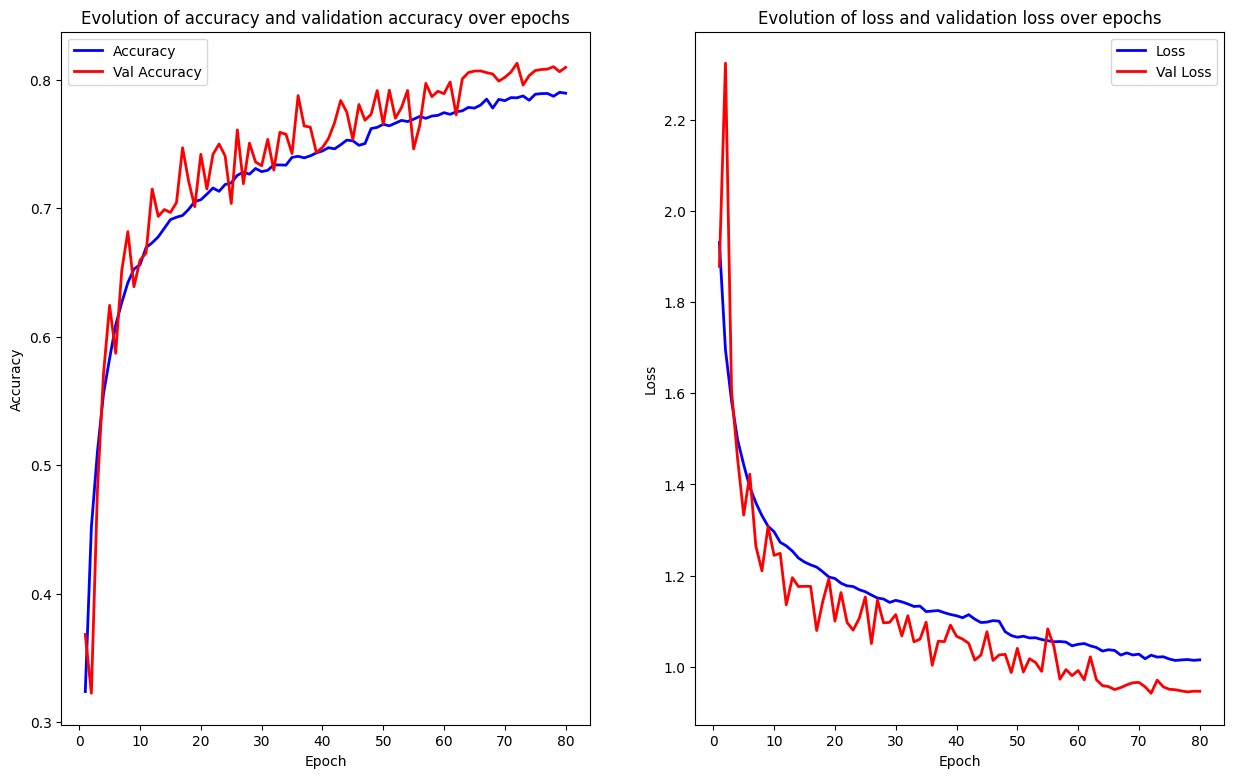

In [26]:
def plot_data_by_epoch(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    loss = history.history['loss']
    v_loss = history.history['val_loss']
    acc = history.history['accuracy']
    v_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(1, 2, figsize=(15,9))
    ax[0].plot(epochs, acc, 'b-', linewidth=2, label='Accuracy')
    ax[0].plot(epochs, v_acc, 'r-', linewidth=2, label='Val Accuracy')
    ax[0].set_title('Evolution of accuracy and validation accuracy over epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')
    
    ax[1].plot(epochs, loss, 'b-', linewidth=2, label='Loss')
    ax[1].plot(epochs, v_loss, 'r-', linewidth=2, label='Val Loss')
    ax[1].set_title('Evolution of loss and validation loss over epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')
    plt.show()

plot_data_by_epoch(history_mnist)
plot_data_by_epoch(history_fashion_mnist)
plot_data_by_epoch(history_cifar10)

Finally, we need to test the model's accuracy for each class and generally. We will display the most important accuracy metrics along with the confusion matrix.

157/157 [==============================] - 1s 4ms/step


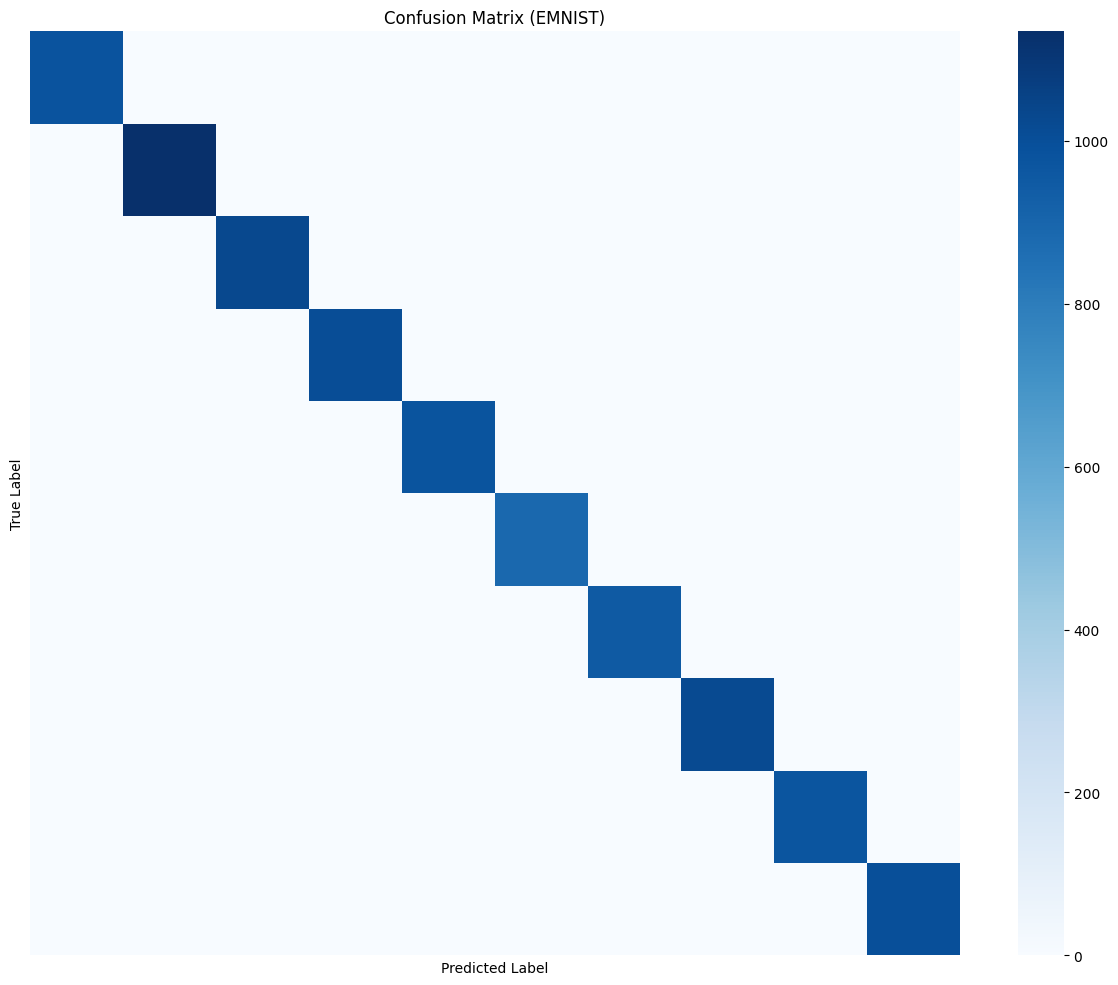

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       0.99      1.00      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

157/157 [==============================] - 1s 3ms/step


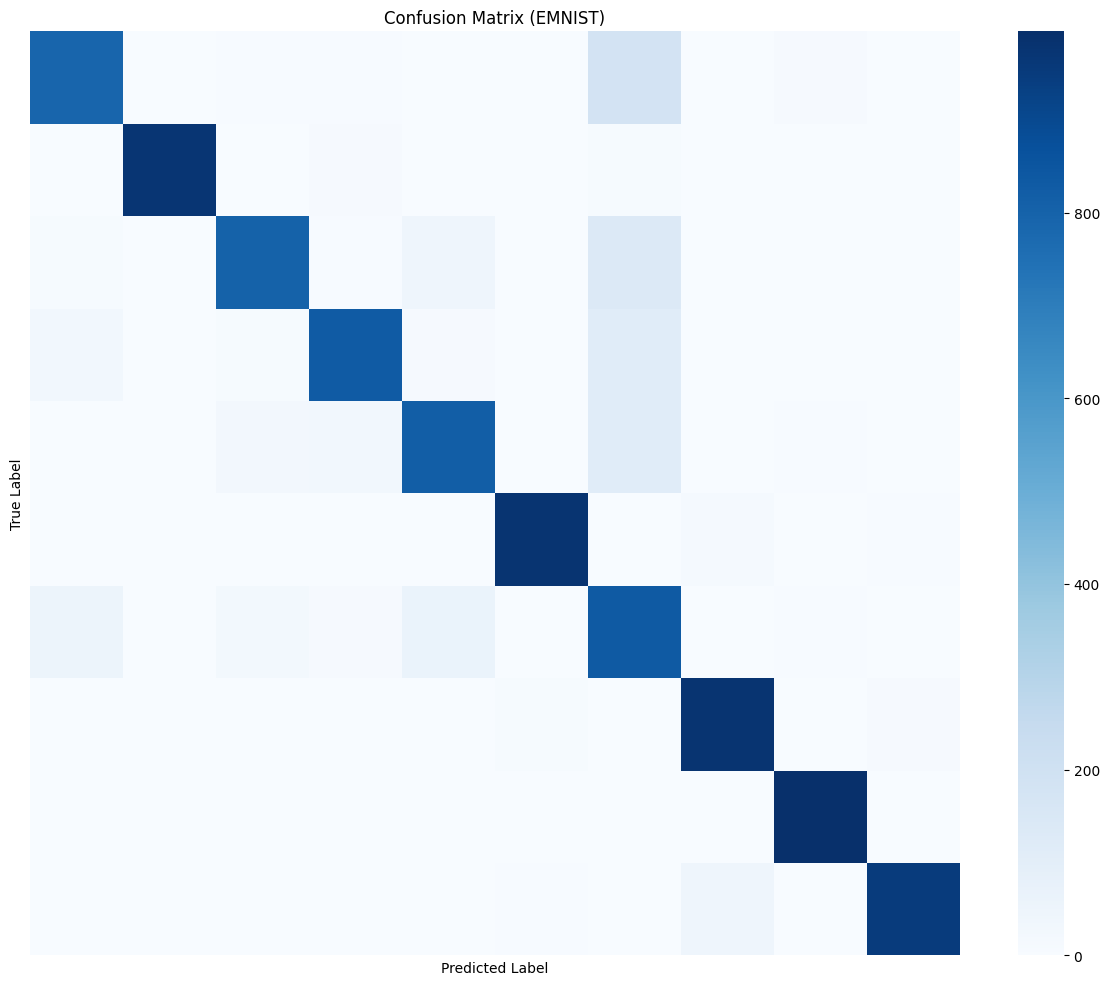

              precision    recall  f1-score   support

           0       0.88      0.79      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.92      0.80      0.86      1000
           3       0.92      0.83      0.87      1000
           4       0.87      0.82      0.84      1000
           5       0.99      0.98      0.98      1000
           6       0.60      0.83      0.70      1000
           7       0.94      0.98      0.96      1000
           8       0.97      0.99      0.98      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.89      0.90     10000

157/157 [==============================] - 1s 4ms/step


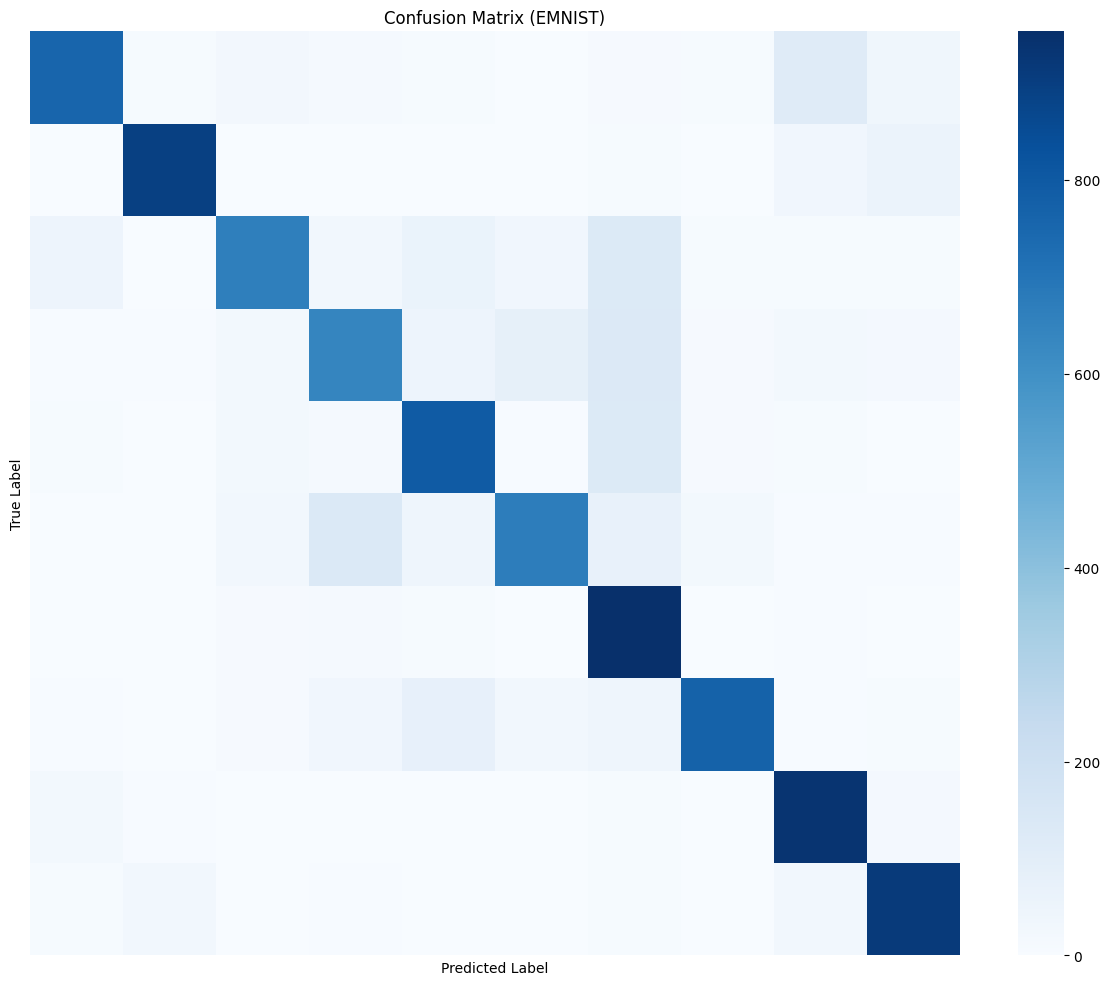

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1000
           1       0.95      0.90      0.92      1000
           2       0.83      0.66      0.74      1000
           3       0.71      0.64      0.67      1000
           4       0.76      0.79      0.78      1000
           5       0.81      0.67      0.73      1000
           6       0.63      0.95      0.76      1000
           7       0.91      0.77      0.83      1000
           8       0.79      0.94      0.86      1000
           9       0.85      0.91      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



In [34]:
def test_model(model, test_dataset, y_test):
    y_pred = model.predict(test_dataset)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
    y_true = y_test.argmax(axis=1)  # Convert one-hot labels back to class labels

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (EMNIST)')
    plt.show()
    
    print(classification_report(y_true, y_pred_classes))

test_model(model_mnist, test_data_mnist, y_true_mnist)
test_model(model_fashion_mnist, test_data_fashion_mnist, y_true_fashion_mnist)
test_model(model_cifar10, test_data_cifar10, y_true_cifar10)

Finally, the most important step: Calculating our model's accuracy on the train data of each dataset.

In [36]:
def get_model_metrics(model, test_data, model_title='model'):
    res = model.evaluate(test_data)
    loss, acc, prec, rec = res
    print(model_title)
    print(f'The accuracy of the model is{acc}')
    print(f'The loss of the model is {loss}')
    print(f'The precision of the model is{prec}')
    print(f'The recall of the model is {rec}')
    print('-----------------------\n')

get_model_metrics(model_mnist, test_data_mnist,model_title='Model metrics for MNIST dataset')
get_model_metrics(model_fashion_mnist, test_data_fashion_mnist, model_title='Model metrics for the fashion MNIST dataset')
get_model_metrics(model_cifar10, test_data_cifar10, model_title = 'Model metrics for the cifar10 dataset')

157/157 [==============================] - 1s 6ms/step - loss: 0.5359 - accuracy: 0.9963 - precision: 0.9972 - recall: 0.9947
Model metrics for MNIST dataset
The accuracy of the model is0.9962999820709229
The loss of the model is 0.5359208583831787
The precision of the model is0.9971929788589478
The recall of the model is 0.994700014591217
-----------------------

157/157 [==============================] - 1s 6ms/step - loss: 0.7564 - accuracy: 0.8945 - precision: 0.9201 - recall: 0.8693
Model metrics for the fashion MNIST dataset
The accuracy of the model is0.8945000171661377
The loss of the model is 0.7564142346382141
The precision of the model is0.9200888872146606
The recall of the model is 0.8693000078201294
-----------------------

157/157 [==============================] - 1s 7ms/step - loss: 0.9675 - accuracy: 0.7994 - precision: 0.8969 - recall: 0.6822
Model metrics for the cifar10 dataset
The accuracy of the model is0.7993999719619751
The loss of the model is 0.967491984367370

These are some very promising results. Lets visualize the predictions to get a better understading of what our predictions portray.

2/2 [==============================] - 0s 13ms/step
The batch's true indices are:
[7 4 6 4 3 0 7 0 2 9 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6
 0 5 4 9 9 2 1 9 4 8 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5]
The batch's predicted indices are:
[7 4 6 4 3 0 7 0 2 9 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6
 0 5 4 9 9 2 1 9 4 8 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5]


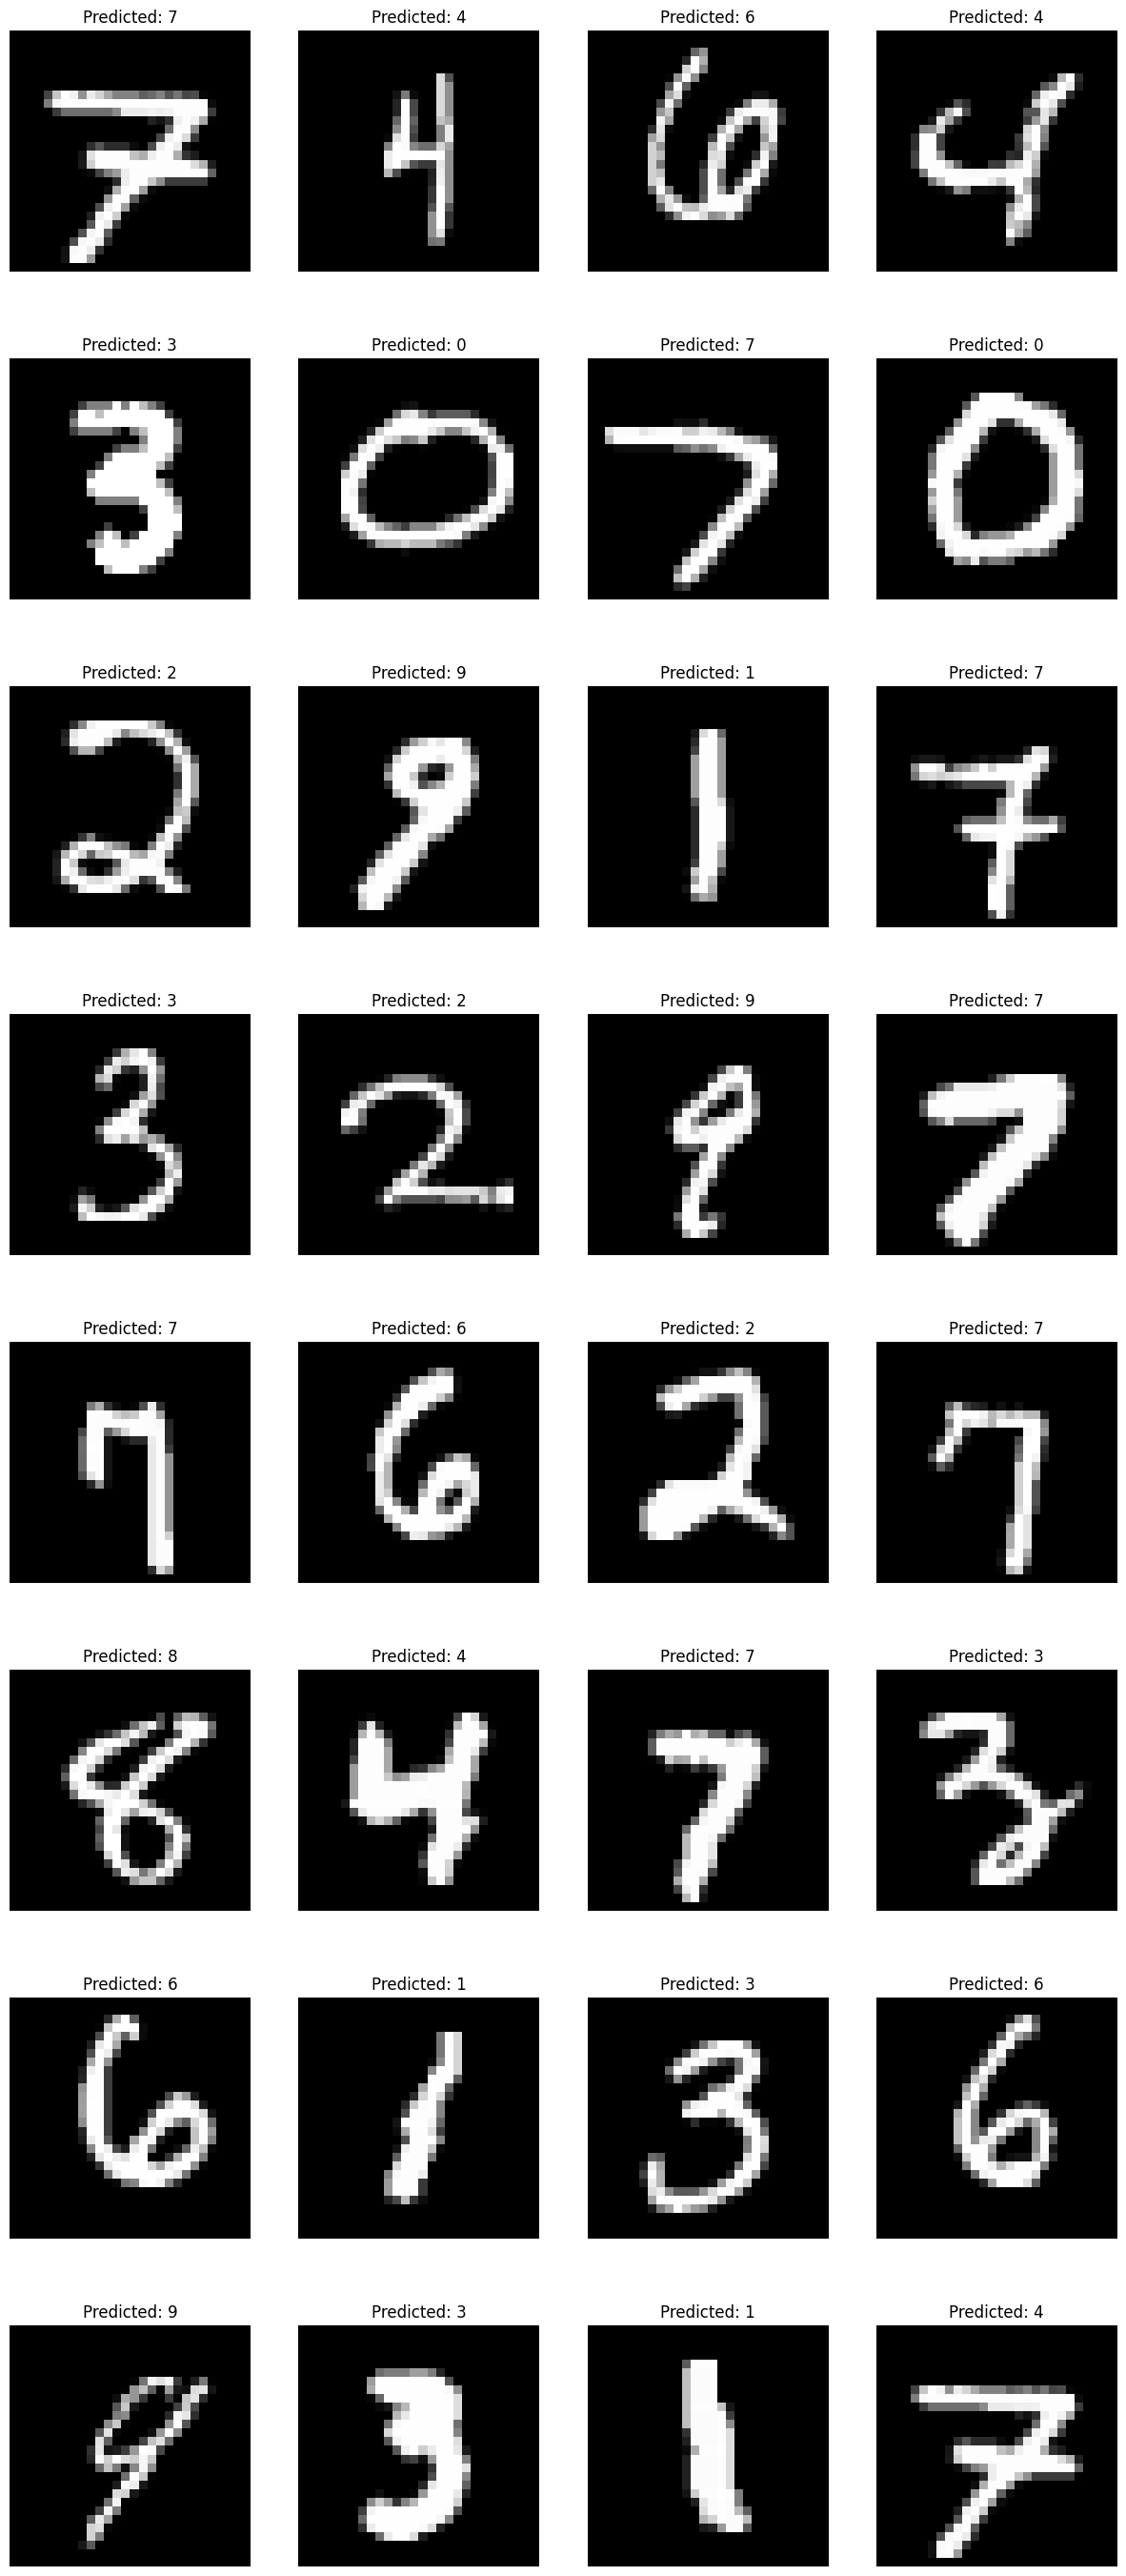

In [39]:
def showcase_data(model, dataset):
    fig, ax = plt.subplots(8, 4, figsize=(15, 35))
    batch_images, batch_true_labels = next(dataset)
    batch_predictions = model.predict(batch_images)
    batch_true_indices = np.argmax(batch_true_labels, axis=1)
    batch_pred_indices = np.argmax(batch_predictions, axis=1)
    
    for i in range(32):
        ax[i // 4, i % 4].imshow(batch_images[i].squeeze(), cmap='gray')
        ax[i // 4, i % 4].axis('off')
        ax[i // 4, i % 4].set_title(f'Predicted: {batch_pred_indices[i]}')
    print("The batch's true indices are:")
    print(batch_true_indices)
    print("The batch's predicted indices are:")
    print(batch_pred_indices)
    plt.imshow(batch_images[0].squeeze(), cmap='gray')

showcase_data(model_mnist, test_data_mnist)

2/2 [==============================] - 0s 10ms/step
The batch's true indices are:
[1 1 2 3 9 8 7 0 2 6 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2 3
 6 7 2 7 8 5 9 9 4 2 5 7 0 5 2 8 6 7 8 0 0 9 9 3 0 8 4]
The batch's predicted indices are:
[1 1 6 3 7 8 7 0 2 6 2 3 1 2 8 4 1 8 5 9 5 0 6 2 0 6 5 3 6 7 1 8 0 1 2 2 3
 6 7 6 7 8 5 7 9 4 2 5 7 0 5 2 8 6 7 8 0 0 9 9 0 0 8 4]


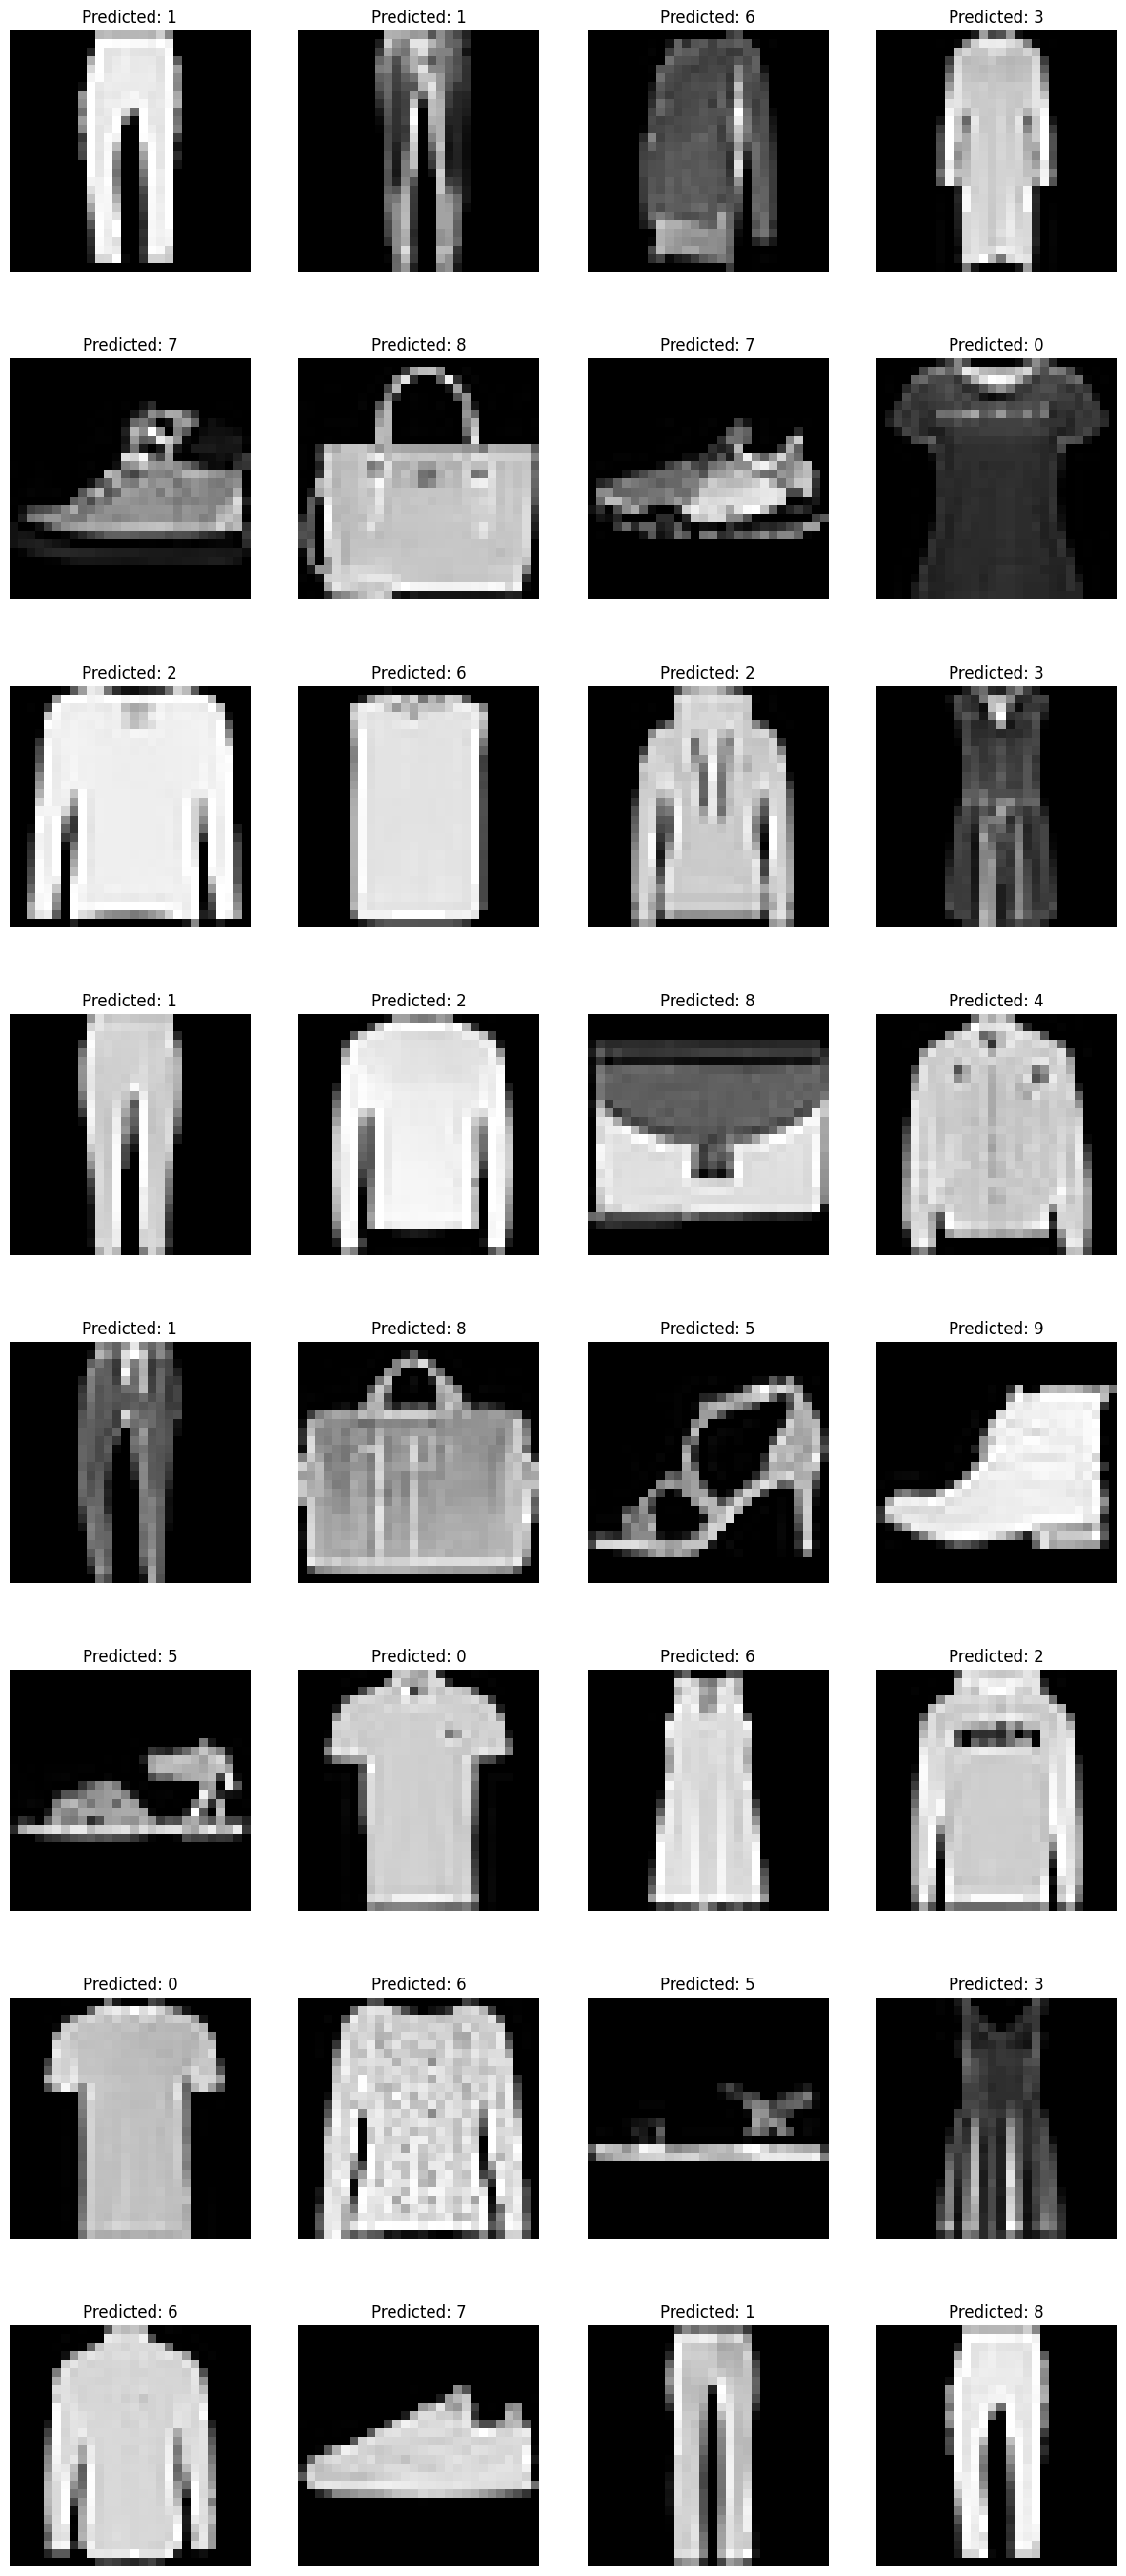

In [40]:
showcase_data(model_fashion_mnist, test_data_fashion_mnist)

2/2 [==============================] - 0s 13ms/step
The batch's true indices are:
[6 2 1 2 3 7 2 6 8 8 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7 4
 5 6 3 1 1 3 6 8 7 4 0 6 2 1 3 0 4 2 7 8 3 1 2 8 0 8 3]
The batch's predicted indices are:
[6 2 8 0 6 7 0 6 8 8 9 2 9 3 5 8 8 1 1 7 2 3 5 7 8 9 0 3 8 6 4 6 6 0 0 7 4
 5 6 3 1 1 6 6 8 5 4 0 2 2 1 3 0 4 6 7 8 3 1 2 8 0 8 3]


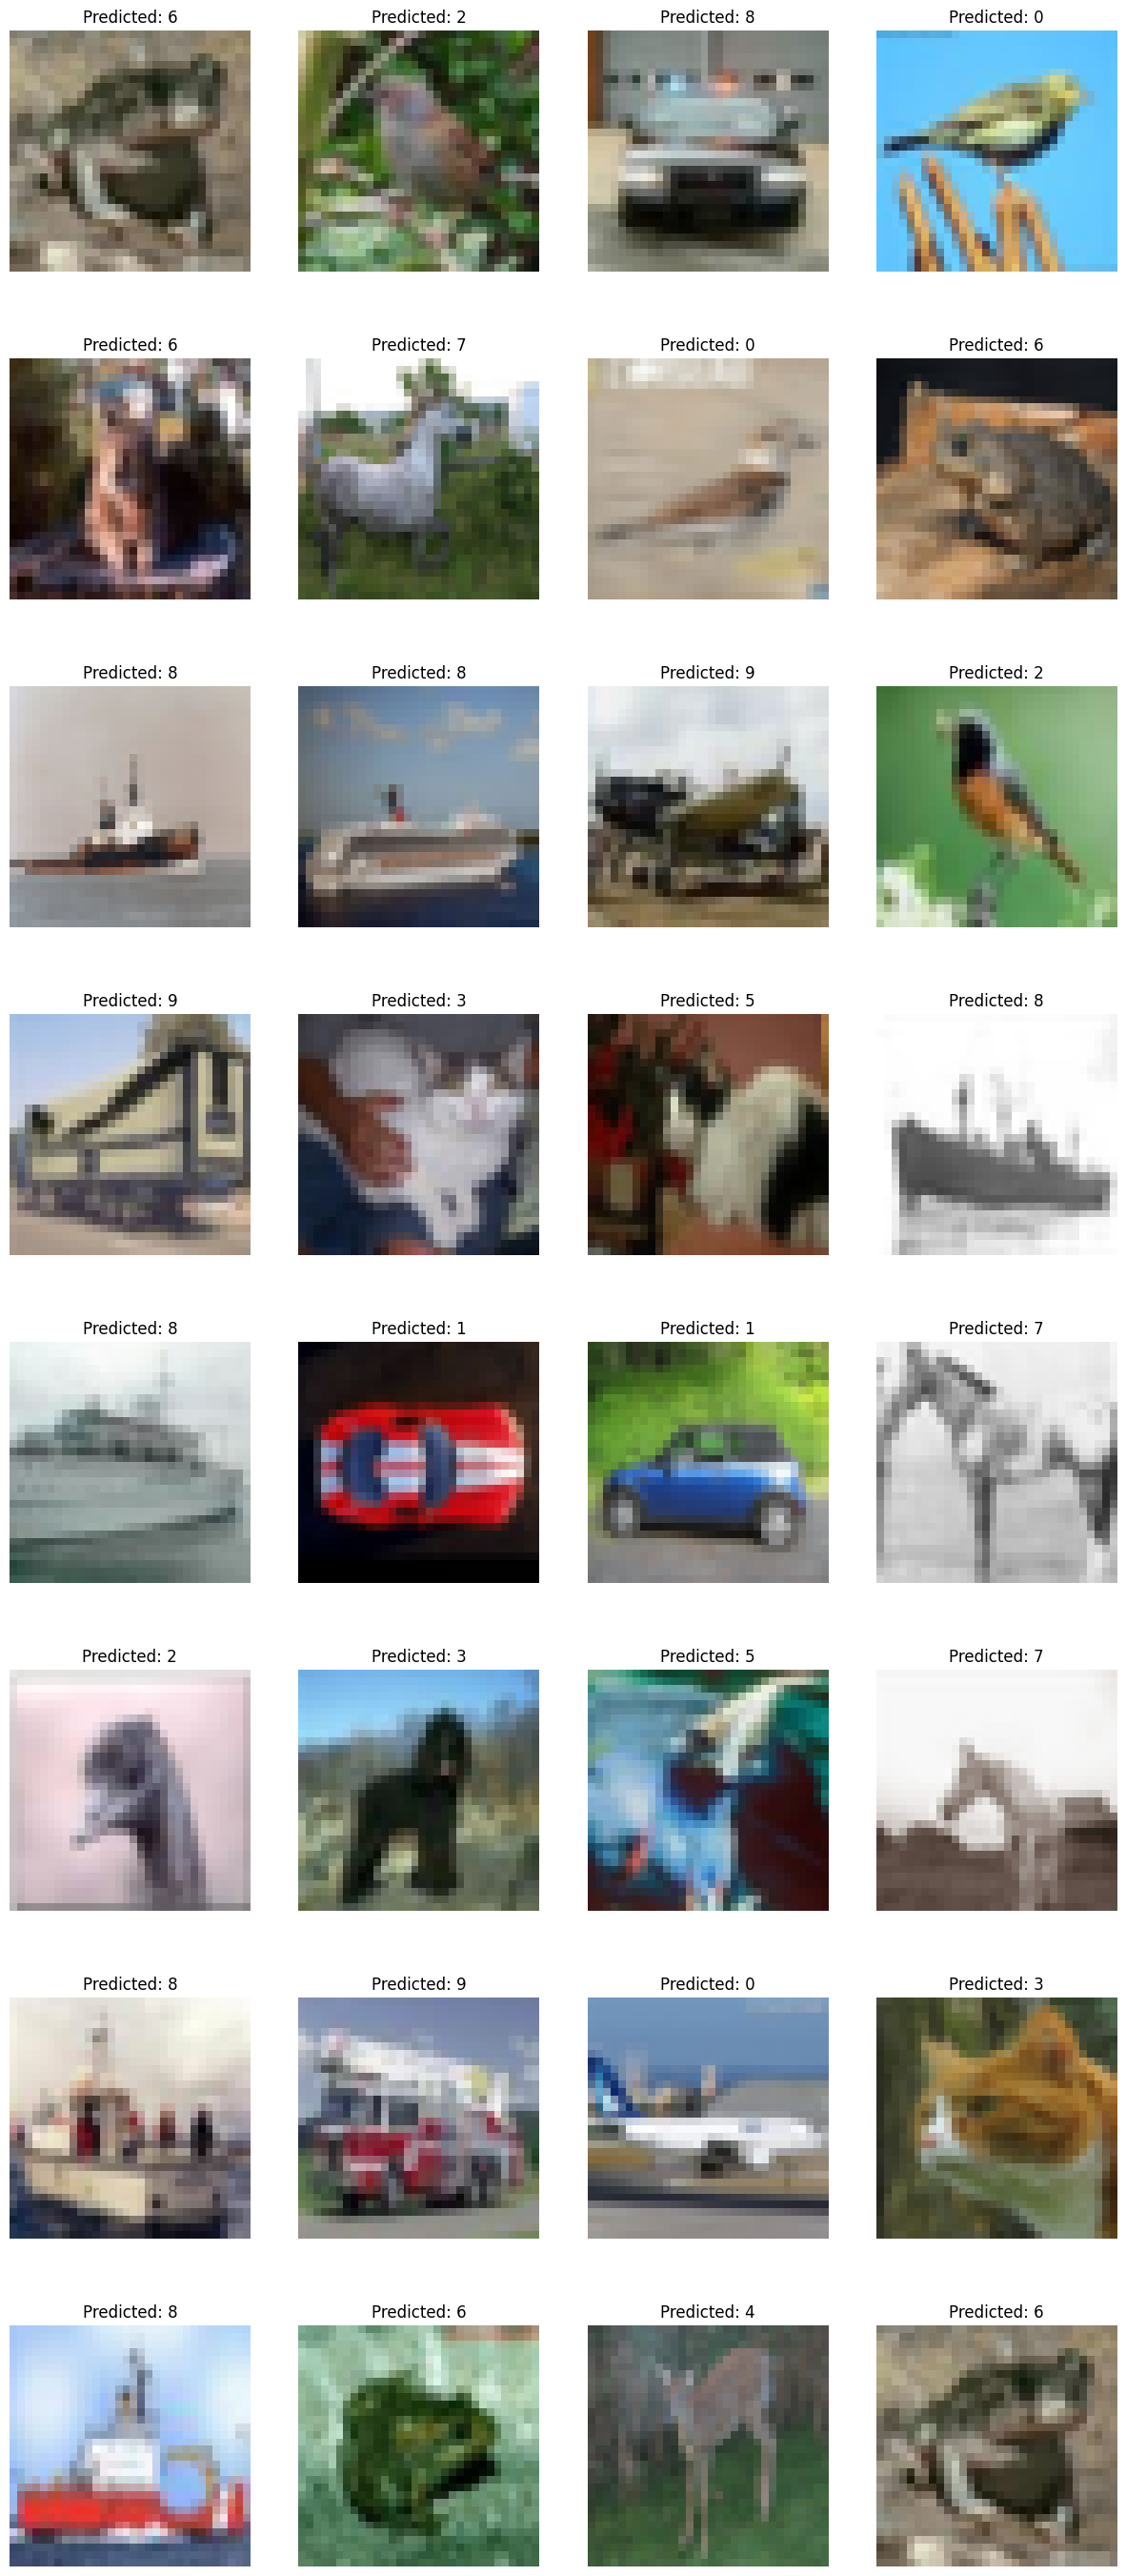

In [41]:
showcase_data(model_cifar10, test_data_cifar10)